This notebook calculates the progression of the size and the overlap to the target of the predicted bounding boxes.

In [ ]:
import pickle
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def load_data(model,mode, dataset, split):
#load predicted and gold bounding boxes
        
    try:

        #the predicted bounding box
        with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
            pred_bbox_list=list(pickle.load(f))

        if mode=="non_inc":
            #the target bounding box
            with open(r"/home/users/fschreiber/project/bboxes_noninc_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
                target_bbox_list=list(pickle.load(f))

        elif mode == "inc":
            #the target bounding box
            with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_target_bbox_list.p","rb") as f:
                target_bbox_list=list(pickle.load(f))
        else:
            print("The mode can only be non_inc or inc")
            return -1,-1,-1,-1,-1

        #the number of one sentence split up incrementally ("the left zebra" would have length 3)
        with open(r"/home/users/fschreiber/project/incremental_pickles/length_incremental_units/"+dataset+"_"+split+"_length_unit.p","rb") as f:
            inc_len=pickle.load(f)

        #the original model data split up incrementally
        data_model=torch.load("/home/users/fschreiber/project/ready_inc_data/"+dataset+"/"+dataset+"_"+split+".pth")

        with open(r"/home/users/fschreiber/project/binary_grouped/"+model+"/"+mode+"/"+dataset+split+".p","rb") as f:
            binary_grouped=pickle.load(f)

        
        if mode=="non_inc":
            target_bbox_list=[x for x,y in zip(target_bbox_list,inc_len) for _ in range(y)]
            
        if model=="TVG":
            pred_bbox_list,target_bbox_list=TVG_prep(pred_bbox_list,target_bbox_list)

            for i in range(len(data_model)):
    
                path="/home/users/fschreiber/project/TransVG/ln_data/other/images/mscoco/images/train2014/"+data_model[i][0]
                image = Image.open(path)
                image_width, image_height = image.size
                
                pred_bbox_list[i]=transform_coordinates(pred_bbox_list[i],image_width,image_height)
                target_bbox_list[i]=transform_coordinates(target_bbox_list[i],image_width,image_height)

        return pred_bbox_list,target_bbox_list,inc_len,data_model,binary_grouped
    
    except FileNotFoundError as e:
        #print(e)
        
        return  -1,-1,-1,-1,-1
    


#TVG needs some extra adjustments to fit the same data format as Resc
def TVG_prep(pred_bbox_list,target_bbox_list):
    #print("TVG")
    for ind,(pred,targ) in enumerate (zip (pred_bbox_list,target_bbox_list)):

        pred=pred.view(1,-1)

        pred=xywh2xyxy(pred)
        pred=torch.clamp(pred,0,1)

        pred_bbox_list[ind]=pred

        targ=targ.view(1,-1)
        targ=xywh2xyxy(targ)

        target_bbox_list[ind]=targ
    return pred_bbox_list,target_bbox_list

#copied from TransVG needed to transform the bounding box vectors
def xywh2xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)



#TVG coordinates are normalized between 0 and 1 reshape them to fit the image
def transform_coordinates(normalized_coords, image_width, image_height):
    # Multiply the normalized coordinates by image size
    pixel_coords = normalized_coords * torch.tensor([[image_width, image_height, image_width, image_height]])

    return pixel_coords

In [3]:
#copied from ReSC
def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if x1y1x2y2:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
    else:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2

    # get the coordinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1, 0) * torch.clamp(inter_rect_y2 - inter_rect_y1, 0)
    # Union Area
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)

    # print(box1, box1.shape)
    # print(box2, box2.shape)
    return inter_area / (b1_area + b2_area - inter_area + 1e-16)



In [4]:
pred_bbox_list,target_bbox_list,inc_len,model,binary_grouped=load_data("TVG","inc","gref_umd","val")


In [5]:
#split up the list into entries where each guess is correct,wrong or mixed save the indices

def split_by_correct(binary_grouped):
    only_one=[]
    only_zero=[]
    mixed=[]
    #mixed_values=[]

    for index,entry in enumerate(binary_grouped):
        if all(p == 1 for p in entry):
            only_one.append(index)
        elif all (p ==0 for p in entry):
            only_zero.append(index)
        else:
            mixed.append(index)
            #mixed_values.append(entry)
    
    return only_one,only_zero,mixed


only_one,only_zero,mixed=split_by_correct(binary_grouped)


In [6]:
#group sentences that belong to one incremental unit
def group_by_increment(bbox_list,inc_len):
    counter=0
    group_list=[]
    for i in inc_len:
        
        group_list.append(bbox_list[counter:counter+i])
        counter=counter+i
    return group_list


pred_group=group_by_increment(pred_bbox_list,inc_len)
targ_group=group_by_increment(target_bbox_list,inc_len)
model_group=group_by_increment(model,inc_len)

In [7]:
#This function calculates the covered area by the prediction bounding boxes through the image
def covered_area(pred_group, ind_list, model_group):

    img_area = []

    for i in range(len(pred_group)):
        
        #Load the image information
        path = "/home/users/fschreiber/project/TransVG/ln_data/other/images/mscoco/images/train2014/" + model_group[i][0][0]

        image = Image.open(path)

        #Calculate and store the image sizes
        image_width, image_height = image.size

        img_area.append(image_width * image_height)



    prog = []
    covered_area = []
    #for each entry in the choosen condition
    for i in ind_list:

        hold_area = []
        hold_cov = []

        # Iterate through the predicted bbox coordinates
        for entry in pred_group[i]:
            
            # Calculate the width and height and area of each predicted bounding box
            width = abs((entry[0][0] - entry[0][2]))
            height = abs((entry[0][1] - entry[0][3]))
            area_bb = width * height
            hold_area.append(area_bb)

            # Calculate the coverage percentage in relation to the image area
            cov_perc = (area_bb / img_area[i]) * 100
            hold_cov.append(cov_perc)

        prog.append(hold_area)
        covered_area.append(hold_cov)

    
    return covered_area


cov_area_one = covered_area(pred_group, only_one, model_group)
cov_area_zero = covered_area(pred_group, only_zero, model_group)
cov_area_mixed = covered_area(pred_group, mixed, model_group)

cov_area_all = cov_area_one + cov_area_zero + cov_area_mixed


In [8]:

def get_progression(pred_group, targ_group, model_group, ind_list, mode):
   
    prog = []

    #Overlap calculates if bounding boxes overlap more
    if mode == "Overlap":
        for k in ind_list:
            
            # Calculate the IoU values between predictions and targets
            hold = []
            for i, j in zip(pred_group[k], targ_group[k]):
                hold.append(bbox_iou(i, j))
            prog.append(hold)
    
    #Size calculates the size progression of bounding boxes
    elif mode == "Size":
        prog = covered_area(pred_group, ind_list, model_group)
    
    else:
        print("mode can only be 'Overlap' or 'Size'. It is:", mode)


    first = []
    last = []

    for entry in prog:
        first.append(entry[0])
        last.append(entry[-1])

    first_avg = sum(first) / len(first)
    last_avg = sum(last) / len(last)
    
    print("The average", mode, "on the first value is:", first_avg)
    print("The average", mode, "on the last value is:", last_avg)
    print()

    return prog, first, last


In [9]:
# Define variables and lists
metric = "Size"
mode = "inc"
model_input = "TVG"
split_list = ["testB", "testA", "val", "test"]
dataset_list = ["unc", "unc+", "gref_umd", "gref"]

# Initialize lists to store first and last values for each split
first_all = []
last_all = []

# Initialize lists to store indices for groups with only one, only zero, and mixed values
one = []
zero = []
mix = []

lenght_model = []

# Iterate through the dataset and split combinations
for file in dataset_list:
    for split in split_list:
        
        # Load data for a specific model, mode, dataset, and split
        pred_bbox_list, target_bbox_list, inc_len, model, binary_grouped = load_data(model_input, mode, file, split)

        # If any of the loaded data is not found, skip to the next iteration
        if pred_bbox_list == -1 or target_bbox_list == -1 or inc_len == -1:
            pass
        else:
            # Print a message combining the dataset and split strings
            print(file + split)

            lenght_model.append(len(binary_grouped))

            # Split by condition
            only_one, only_zero, mixed = split_by_correct(binary_grouped)

            # Append the indices
            one.append(only_one)
            zero.append(only_zero)
            mix.append(mixed)

            # Group data
            pred_group = group_by_increment(pred_bbox_list, inc_len)
            targ_group = group_by_increment(target_bbox_list, inc_len)
            model_group = group_by_increment(model, inc_len)

            # Calculate the progression of the data and the first and last value
            prog, first, last = get_progression(pred_group, targ_group, model_group, only_one, metric)

            first_all.append(first)
            last_all.append(last)

# Flatten lists
first_all = [item for sublist in first_all for item in sublist]
last_all = [item for sublist in last_all for item in sublist]

# Calculate the average first and last values
first_all_avg = sum(first_all) / len(first_all)
last_all_avg = sum(last_all) / len(last_all)
print(first_all_avg)
print(last_all_avg)


unctestB
The average Size on the first value is: tensor(17.4190)
The average Size on the last value is: tensor(17.0471)

unctestA
The average Size on the first value is: tensor(18.2785)
The average Size on the last value is: tensor(18.1047)

uncval
The average Size on the first value is: tensor(17.8803)
The average Size on the last value is: tensor(17.6603)

unc+testB
The average Size on the first value is: tensor(18.6077)
The average Size on the last value is: tensor(18.1426)

unc+testA
The average Size on the first value is: tensor(18.5406)
The average Size on the last value is: tensor(18.3486)

unc+val
The average Size on the first value is: tensor(18.5377)
The average Size on the last value is: tensor(18.2679)

gref_umdval
The average Size on the first value is: tensor(16.7681)
The average Size on the last value is: tensor(16.5565)

gref_umdtest
The average Size on the first value is: tensor(16.1692)
The average Size on the last value is: tensor(16.0806)

grefval
The average Size o

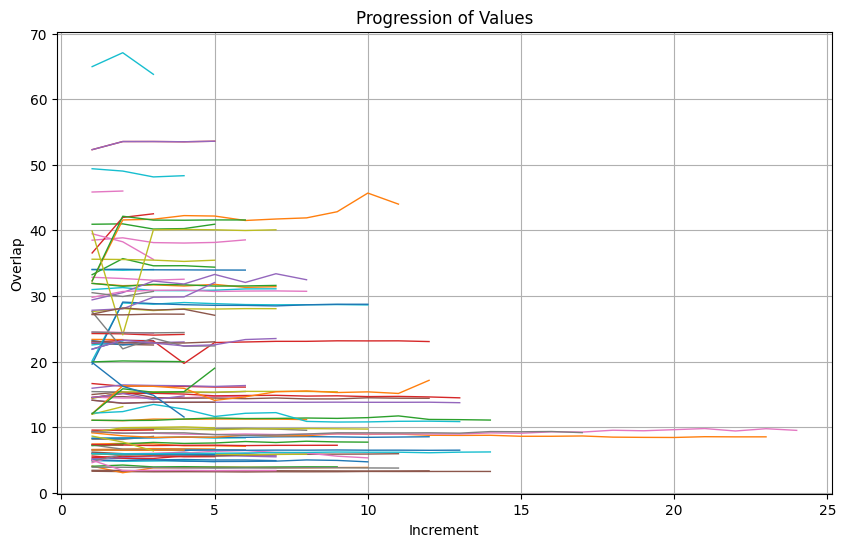

In [10]:
#visualize the results for a subset of values
data = prog[100:200]
    

# Flatten list
flat_data = [val.item() for sublist in data for val in sublist]

x_values = [i + 1 for sublist in data for i in range(len(sublist))]

plt.figure(figsize=(10, 6)) 

# Plot each sublist separately with different colors
for i, sublist in enumerate(data):
    y_values = [val.item() for val in sublist]
    x_values = range(1, len(sublist) + 1)
    plt.plot(x_values, y_values, linewidth=1, label=f'Line {i+1}')

plt.xlabel('Increment')
plt.ylabel('Overlap')
plt.title('Progression of Values')
plt.grid(True)
plt.show()


In [11]:
#model_group[0][-1][0]
#pred_group[0]
binary_grouped[0][-1]





TypeError: 'int' object is not subscriptable

In [ ]:
counter=-1
d={}
for model,j in zip(model_group,binary_grouped):
    
    counter=counter+1
    
    img_num=model[-1][0]

    res=j[-1]
    
    if img_num not in d:
        d[img_num] = [(counter,res)]
    else:
        d[img_num].append((counter,res))


In [ ]:
def calculate_smc(binary_list):
    total_elements = len(binary_list)
    agreement_count = sum(value for index, value in binary_list)
    return agreement_count / total_elements

# Your dictionary with binary lists

smc_results = []

# Calculate SMC for each binary list and store the results in a list
for key, binary_list in d.items():
    smc_value = calculate_smc(binary_list)
    smc_results.append((key, smc_value))

print(smc_results)


[('COCO_train2014_000000000309.jpg', 0.5), ('COCO_train2014_000000000795.jpg', 1.0), ('COCO_train2014_000000001261.jpg', 0.75), ('COCO_train2014_000000001407.jpg', 0.6666666666666666), ('COCO_train2014_000000001994.jpg', 0.3333333333333333), ('COCO_train2014_000000002411.jpg', 0.5), ('COCO_train2014_000000002892.jpg', 1.0), ('COCO_train2014_000000003178.jpg', 1.0), ('COCO_train2014_000000003320.jpg', 1.0), ('COCO_train2014_000000004477.jpg', 1.0), ('COCO_train2014_000000004830.jpg', 0.5), ('COCO_train2014_000000005587.jpg', 0.6), ('COCO_train2014_000000005862.jpg', 0.25), ('COCO_train2014_000000006068.jpg', 0.5), ('COCO_train2014_000000007393.jpg', 0.75), ('COCO_train2014_000000007504.jpg', 0.3333333333333333), ('COCO_train2014_000000007601.jpg', 0.6), ('COCO_train2014_000000007653.jpg', 1.0), ('COCO_train2014_000000007746.jpg', 1.0), ('COCO_train2014_000000007852.jpg', 1.0), ('COCO_train2014_000000008063.jpg', 0.5), ('COCO_train2014_000000008300.jpg', 0.2), ('COCO_train2014_0000000088

[0.5, 1.0, 0.75, 0.6666666666666666, 0.3333333333333333, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.6, 0.25, 0.5, 0.75, 0.3333333333333333, 0.6, 1.0, 1.0, 1.0, 0.5, 0.2, 0.6666666666666666, 0.5, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 0.5, 0.5, 0.75, 0.75, 1.0, 1.0, 1.0, 1.0, 0.75, 0.5, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 0.5, 0.6666666666666666, 0.0, 1.0, 1.0, 0.5, 1.0, 0.75, 0.5, 0.75, 0.7142857142857143, 1.0, 0.5, 0.0, 0.75, 0.5, 0.75, 0.3333333333333333, 1.0, 0.5, 1.0, 0.3333333333333333, 0.7142857142857143, 0.5, 1.0, 1.0, 0.6666666666666666, 0.8333333333333334, 1.0, 0.75, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.0, 0.625, 0.5, 0.0, 1.0, 0.75, 0.0, 1.0, 1.0, 0.75, 0.5, 0.6666666666666666, 1.0, 0.6666666666666666, 0.6666666666666666, 0.75, 0.5, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.75, 0.25, 0.0, 1.0, 1.0, 0.5, 0.625, 1.0, 0.0, 0.0, 1.0, 0.25, 1.0, 0.25, 0.5, 1.0, 0.25, 0.5, 0.25, 1.0, 1.0, 0.625, 1.0, 1.0, 1.0, 0.5, 0.0, 0.666666666666666

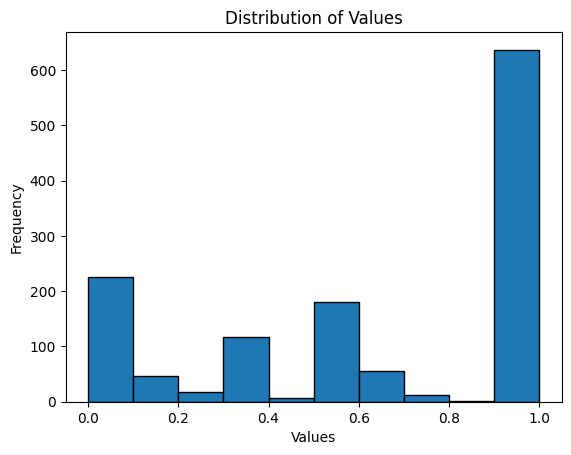

In [ ]:
values = [item[1] for item in smc_results]
print(values)
values=[2 * abs(0.5 - x) for x in values]
#print(values)

# Plot the histogram
plt.hist(values, bins=10, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Values')
plt.show()